## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W1022 14:42:20.941283 13032 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1022 14:42:21.451051 13032 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1022 14:42:23.380065 13032 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 14:42:23.432002 13032 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 14:42:23.616878 13032 

Experiment with Regulizer = 0.010000


W1022 14:42:24.740229 13032 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W1022 14:42:26.088454 13032 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 313us/step - loss: 199.7787 - acc: 0.2369 - val_loss: 38.7255 - val_acc: 0.2630
Epoch 2/50
50000/50000 [==============================] - 11s 221us/step - loss: 16.1912 - acc: 0.1183 - val_loss: 5.1554 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 13s 262us/step - loss: 3.2183 - acc: 0.1000 - val_loss: 2.4724 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 14s 274us/step - loss: 2.4633 - acc: 0.0969 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 14s 279us/step - loss: 2.4625 - acc: 0.0987 - val_loss: 2.4626 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 14s 284us/step - loss: 2.4625 - acc: 0.0972 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 14s 280us/step - loss: 2.4625 - acc: 0.0993 - val_loss

50000/50000 [==============================] - 14s 286us/step - loss: 10.7823 - acc: 0.2606 - val_loss: 10.1899 - val_acc: 0.3249
Epoch 2/50
50000/50000 [==============================] - 13s 270us/step - loss: 9.7273 - acc: 0.3506 - val_loss: 9.2978 - val_acc: 0.3668
Epoch 3/50
50000/50000 [==============================] - 14s 273us/step - loss: 8.9154 - acc: 0.3765 - val_loss: 8.5530 - val_acc: 0.3866
Epoch 4/50
50000/50000 [==============================] - 14s 273us/step - loss: 8.2306 - acc: 0.3910 - val_loss: 7.9303 - val_acc: 0.3915
Epoch 5/50
50000/50000 [==============================] - 14s 272us/step - loss: 7.6447 - acc: 0.4029 - val_loss: 7.3810 - val_acc: 0.4106
Epoch 6/50
50000/50000 [==============================] - 14s 278us/step - loss: 7.1389 - acc: 0.4129 - val_loss: 6.9084 - val_acc: 0.4167
Epoch 7/50
50000/50000 [==============================] - 14s 272us/step - loss: 6.7005 - acc: 0.4183 - val_loss: 6.5066 - val_acc: 0.4204
Epoch 8/50
50000/50000 [============

Epoch 2/50
50000/50000 [==============================] - 14s 270us/step - loss: 5.9489 - acc: 0.3602 - val_loss: 5.5987 - val_acc: 0.3782
Epoch 3/50
50000/50000 [==============================] - 13s 269us/step - loss: 5.2975 - acc: 0.3843 - val_loss: 5.0052 - val_acc: 0.3938
Epoch 4/50
50000/50000 [==============================] - 13s 264us/step - loss: 4.7530 - acc: 0.3998 - val_loss: 4.5115 - val_acc: 0.4016
Epoch 5/50
50000/50000 [==============================] - 13s 268us/step - loss: 4.2946 - acc: 0.4087 - val_loss: 4.0871 - val_acc: 0.4183
Epoch 6/50
50000/50000 [==============================] - 14s 272us/step - loss: 3.9025 - acc: 0.4197 - val_loss: 3.7292 - val_acc: 0.4188
Epoch 7/50
50000/50000 [==============================] - 14s 270us/step - loss: 3.5674 - acc: 0.4249 - val_loss: 3.4186 - val_acc: 0.4304
Epoch 8/50
50000/50000 [==============================] - 14s 271us/step - loss: 3.2826 - acc: 0.4342 - val_loss: 3.1625 - val_acc: 0.4363
Epoch 9/50
50000/50000 [===

Epoch 3/50
50000/50000 [==============================] - 13s 270us/step - loss: 5.3194 - acc: 0.3793 - val_loss: 5.0262 - val_acc: 0.3887
Epoch 4/50
50000/50000 [==============================] - 13s 268us/step - loss: 4.7714 - acc: 0.3942 - val_loss: 4.5253 - val_acc: 0.4104
Epoch 5/50
50000/50000 [==============================] - 14s 285us/step - loss: 4.3078 - acc: 0.4073 - val_loss: 4.0991 - val_acc: 0.4148
Epoch 6/50
50000/50000 [==============================] - 14s 272us/step - loss: 3.9161 - acc: 0.4155 - val_loss: 3.7402 - val_acc: 0.4182
Epoch 7/50
50000/50000 [==============================] - 14s 271us/step - loss: 3.5805 - acc: 0.4230 - val_loss: 3.4363 - val_acc: 0.4233
Epoch 8/50
50000/50000 [==============================] - 14s 273us/step - loss: 3.2937 - acc: 0.4308 - val_loss: 3.1685 - val_acc: 0.4354
Epoch 9/50
50000/50000 [==============================] - 14s 273us/step - loss: 3.0474 - acc: 0.4389 - val_loss: 2.9400 - val_acc: 0.4394
Epoch 10/50
50000/50000 [==

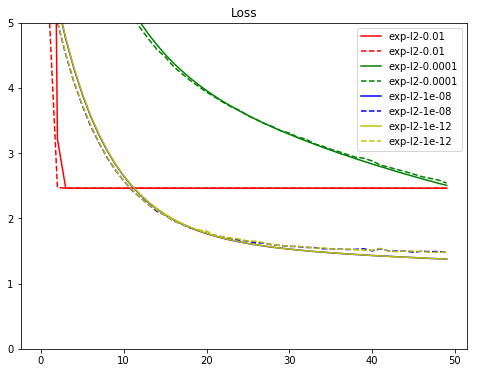

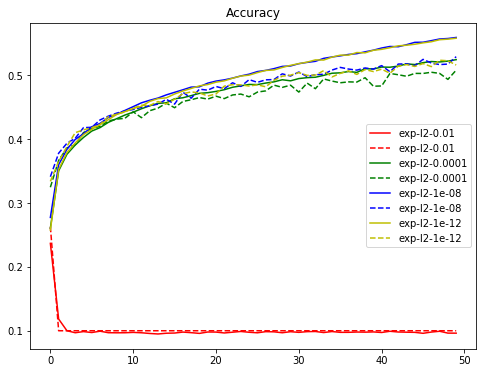

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()